In [1]:
import plotly.graph_objects as go
import numpy as np
import os
import pickle
import webcolors
import pandas as pd

In [2]:
def to_opacity(name, opacity):
    r, g, b = webcolors.name_to_rgb(name)
    return f"rgba({r}, {g}, {b}, {opacity})"

In [3]:
def get_results(filename, rolling_len=200):
    with open(filename, "rb") as file:
        results = pickle.load(file)
    if len(results[0]) < 5000:
        new_results = []
        for row in results:
            new_results.append([])
            # because ppo from stable-baselines logs after 100 steps
            for item in row:
                new_results[-1].extend([item]*100)
        n = len(new_results[0])
        n = (n // 10000) * 10000
        results = [row[:n] for row in new_results]
    dirname = os.path.dirname(filename)
    rolled_up = []
    frame = []
    for result in results:
        r = pd.Series(result).rolling(rolling_len, min_periods=1).mean().dropna()
        r = list(r)
        rolled_up.append(r)
    frame = pd.DataFrame.from_records(frame)
    rolled_up = np.array(rolled_up)

    avg_rewards = np.mean(rolled_up, 0)
    min_rewards = rolled_up.min(0)
    max_rewards = rolled_up.max(0)
    std_rewards = rolled_up.std(0)

    bot = np.maximum(avg_rewards - std_rewards, min_rewards)
    top = np.minimum(avg_rewards + std_rewards, max_rewards)
    return avg_rewards, bot, top

def to_paper_name(algo: str):
    if algo.startswith("sf_reinforce"):
        return algo.replace("sf_reinforce", "SFR1")
    if algo.startswith("two_sided_sf_reinforce"):
        return algo.replace("two_sided_sf_reinforce", "SFR2")
    return algo

In [4]:
def plot_values(
    fig: go.Figure,
    avg_rewards: np.ndarray,
    top: np.ndarray,
    bot: np.ndarray,
    algo: str,
    color: str,
):
    fig.add_trace(
        go.Scatter(
            y=bot,
            mode="lines",
            line=dict(width=0.01, color=color),
            showlegend=False,
        )
    )  # fill down to xaxis
    fig.add_trace(
        go.Scatter(
            y=top,
            mode="lines",
            line=dict(width=0.01, color=color),
            fill="tonexty",
            fillcolor=to_opacity(color, 0.1),
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            y=avg_rewards,
            mode="lines",
            line=dict(width=2, color=color),
            name=algo,
        )
    )


def update_layout(fig, title):
    fig.update_layout(
        legend=dict(yanchor="bottom", y=0.01, xanchor="right", x=0.99),
        autosize=False,
        width=571,
        height=457,
        plot_bgcolor="white",
        margin=dict(l=20, r=20, t=50, b=20),
        title={
            "text": title,
            "x": 0.53,
            "font": {"size": 15},
        },
    )
    fig.update_xaxes(
        title_text="Episodes",
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
        gridcolor="lightgrey",
    )
    fig.update_yaxes(
        title_text="Discounted Sum of Rewards",
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
        gridcolor="lightgrey",
    )

# Base

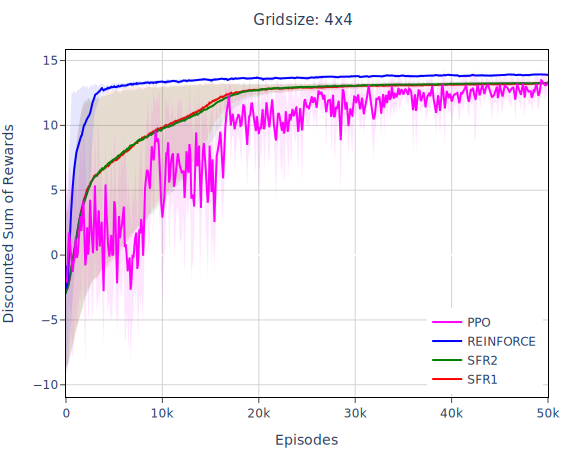

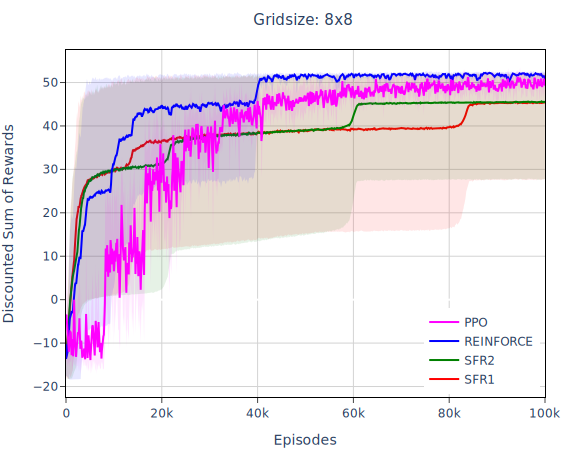

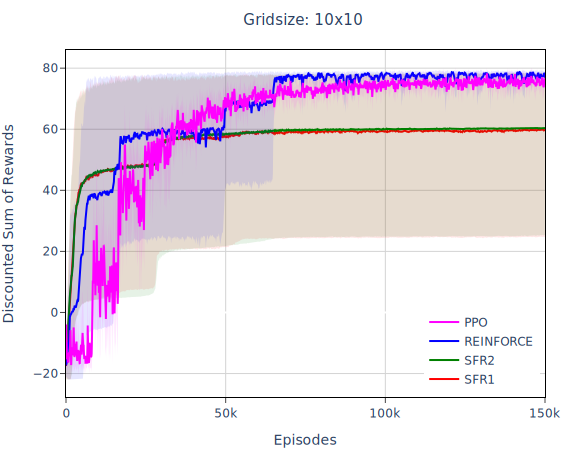

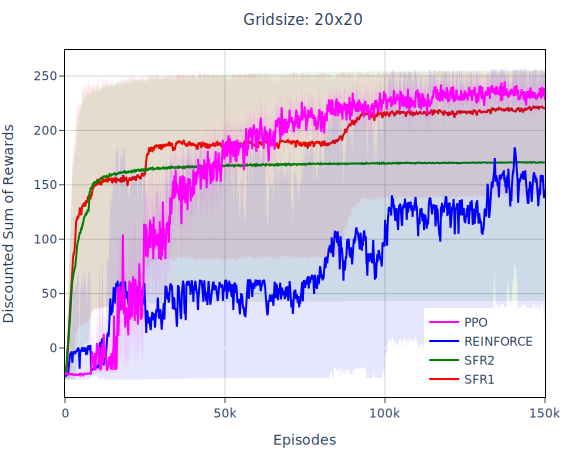

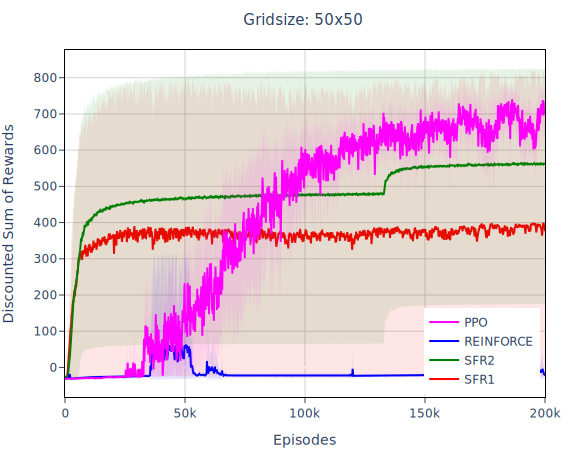

In [5]:
gridsizes = ["4x4"]
colors = ["red", "green", "blue", "magenta"]
algos = ['sf_reinforce', 'two_sided_sf_reinforce', 'reinforce', "ppo"]
gridsizes = ["4x4", "8x8", "10x10", "20x20", "50x50"]
grids = ['tiny', 'small', 'medium', 'medium20', 'large']
for grid, gridsize in zip(grids, gridsizes):
    fig = go.Figure()
    for color, algo in zip(colors, algos):
        dirname = os.path.join("saves", algo, grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        avg_rewards, bot, top = get_results(path)
        plot_values(fig, avg_rewards, top, bot, to_paper_name(algo).upper(), color)

    title = f"Gridsize: {gridsize}"
    update_layout(fig, title)
    fig.write_image(f"plotly_images/{grid}.png", scale=2)
    fig.show(renderer="svg")

### Table

In [6]:
# table for experiment 1 different sizes, different algorithm
frame = []
gridsizes = ["4x4", "8x8", "10x10", "20x20", "50x50"]
for algo in "reinforce ppo a2c sf_reinforce two_sided_sf_reinforce".split():
    for grid, gridsize in zip("tiny small medium medium20 large".split(), gridsizes):
        dirname = os.path.join("saves", algo, grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        with open(path, "rb") as file:
            results = np.array(pickle.load(file))

        per_seed_results = results[:, -200:].mean(1)
        disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
        frame.append((algo, gridsize, disp))
frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
frame.columns = ["Algorithm / Gridsize"] + [col for _, col in frame.columns][1:]
frame = frame[["Algorithm / Gridsize"] + gridsizes]
display(frame)
print(
    frame
    .to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)


Algorithm / Gridsize           4x4             8x8          10x10  \
0                     a2c  14.20 +- 0.0  -10.11 +- 20.9  -9.60 +- 29.7   
1                     ppo  12.72 +- 0.2    49.72 +- 0.2   75.38 +- 0.3   
2               reinforce  13.90 +- 0.1    50.74 +- 2.3   76.90 +- 4.9   
3            sf_reinforce  13.23 +- 0.1   45.40 +- 17.7  59.80 +- 35.0   
4  two_sided_sf_reinforce  13.26 +- 0.1   45.52 +- 17.8  60.39 +- 35.0   

             20x20            50x50  
0    -0.40 +- 82.5    -28.75 +- 5.4  
1    235.09 +- 1.9   682.97 +- 12.9  
2  144.89 +- 113.8    -18.79 +- 8.4  
3   220.24 +- 78.8  376.29 +- 401.4  
4  170.68 +- 127.4  562.89 +- 387.7

\begin{tabular}{llllll}
\hline
Algorithm / Gridsize & 4x4 & 8x8 & 10x10 & 20x20 & 50x50 \\
\hline
a2c & 14.20 $\pm$ 0.0 & -10.11 $\pm$ 20.9 & -9.60 $\pm$ 29.7 & -0.40 $\pm$ 82.5 & -28.75 $\pm$ 5.4 \\
ppo & 12.72 $\pm$ 0.2 & 49.72 $\pm$ 0.2 & 75.38 $\pm$ 0.3 & 235.09 $\pm$ 1.9 & 682.97 $\pm$ 12.9 \\
reinforce & 13.90 $\pm$ 0.1 & 50.74 $\pm$ 2.3 & 76.90 $\pm$ 4.9 & 144.89 $\pm$ 113.8 & -18.79 $\pm$ 8.4 \\
sf\_reinforce & 13.23 $\pm$ 0.1 & 45.40 $\pm$ 17.7 & 59.80 $\pm$ 35.0 & 220.24 $\pm$ 78.8 & 376.29 $\pm$ 401.4 \\
two\_sided\_sf\_reinforce & 13.26 $\pm$ 0.1 & 45.52 $\pm$ 17.8 & 60.39 $\pm$ 35.0 & 170.68 $\pm$ 127.4 & 562.89 $\pm$ 387.7 \\
\hline
\end{tabular}



# Perturbation sizes

## Medium

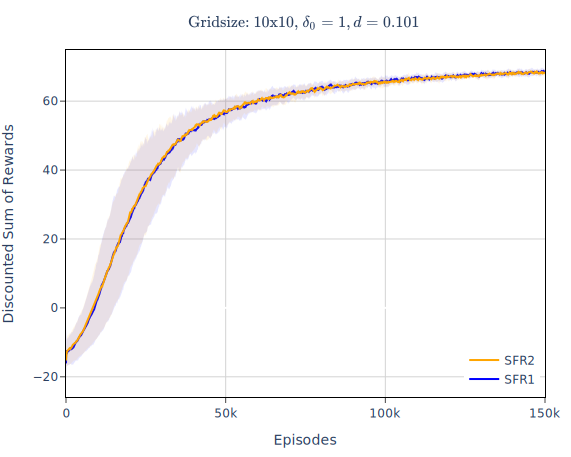

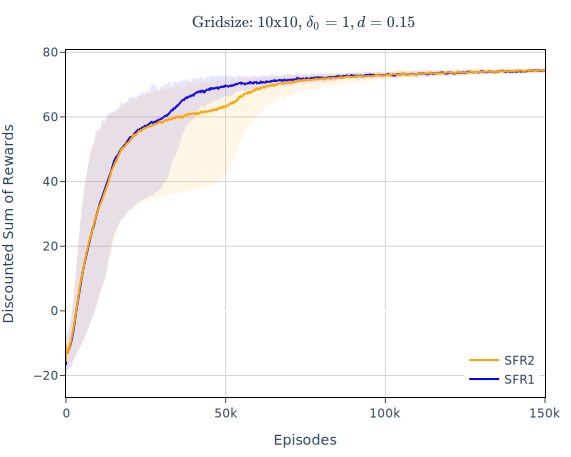

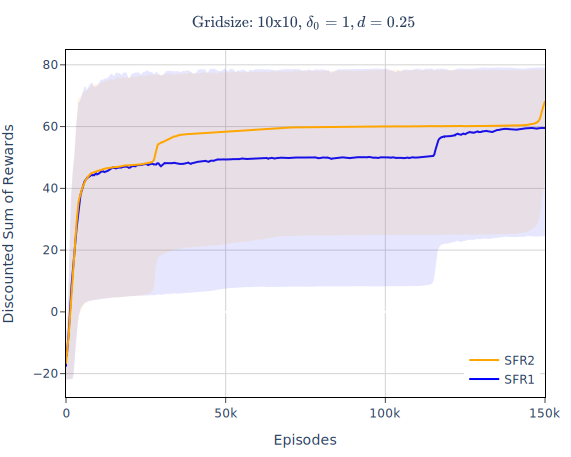

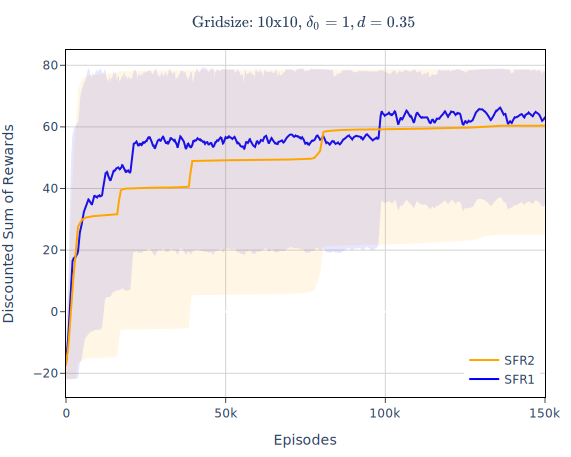

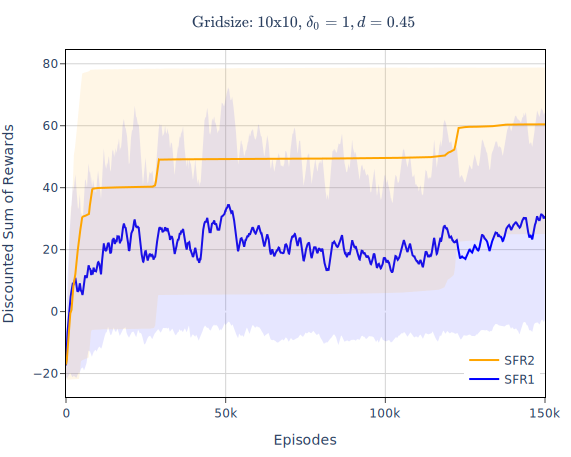

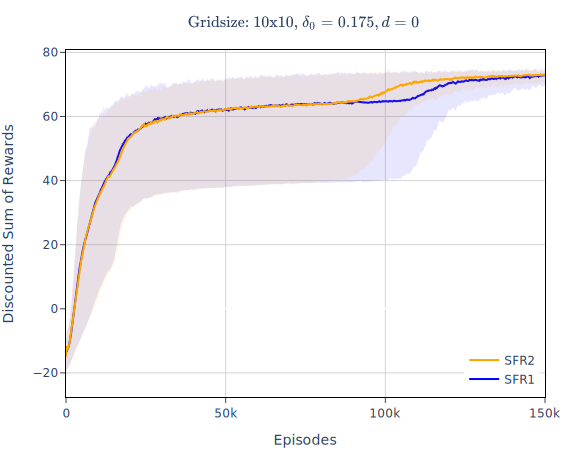

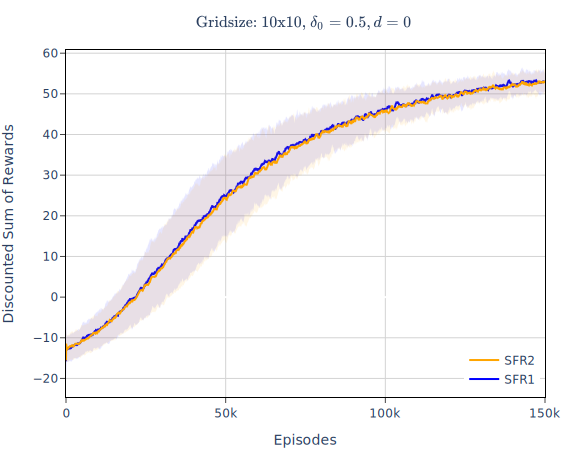

In [7]:
grid, gridsize = "medium", "10x10"
suffixes = ['0.101', '0.15', '0.25', '0.35', '0.45', 'const_0.175', 'const_0.5']
algos = ["sf_reinforce", "two_sided_sf_reinforce"]
colors = ["blue", "orange"]
for suffix in suffixes:
    fig = go.Figure()
    for algo, color in zip(algos, colors):
        name = algo + "_" + suffix
        dirname = os.path.join("saves", name, grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        avg_rewards, bot, top = get_results(path, 800)
        plot_values(fig, avg_rewards, top, bot, to_paper_name(algo), color)
    if suffix.startswith('const'):
        title = fr"$\text{{Gridsize: {gridsize}, }} \delta_0={suffix[6:]}, d=0$"
        save_name = fr"plotly_images/sfr_{suffix}.png"
    else:
        title = fr"$\text{{Gridsize: {gridsize}, }} \delta_0=1, d={suffix}$"
        save_name = f"plotly_images/sfr{suffix}.png"

    # title = f"Gridsize: {gridsize}"
    update_layout(fig, title)
    fig.write_image(save_name, scale=2)
    fig.show(renderer="svg")

## Large

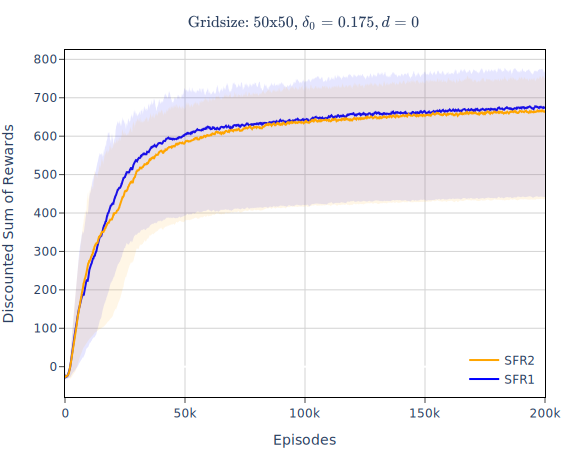

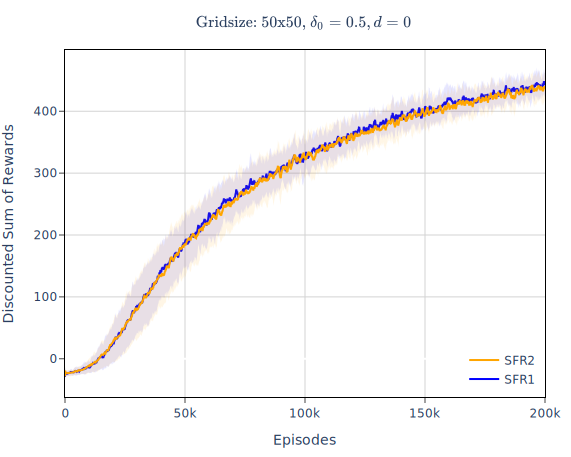

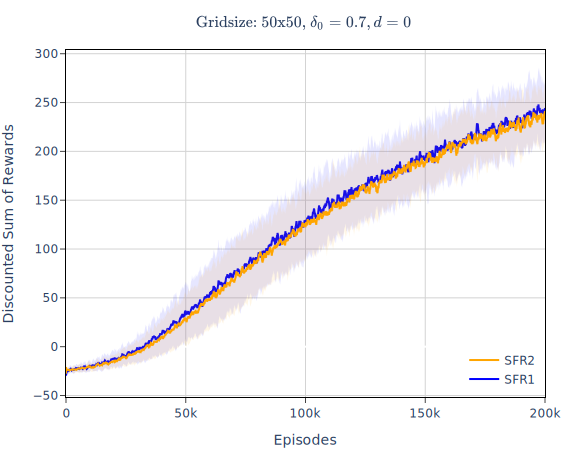

In [8]:
grid, gridsize = "large", "50x50"
suffixes = ['const_0.175', 'const_0.5', 'const_0.7']
algos = ["sf_reinforce", "two_sided_sf_reinforce"]
colors = ["blue", "orange"]
for suffix in suffixes:
    fig = go.Figure()
    for algo, color in zip(algos, colors):
        name = algo + "_" + suffix
        dirname = os.path.join("saves", name, grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        avg_rewards, bot, top = get_results(path, 800)
        plot_values(fig, avg_rewards, top, bot, to_paper_name(algo), color)

    title = fr"$\text{{Gridsize: {gridsize}, }} \delta_0={suffix[6:]}, d=0$"
    save_name = fr"plotly_images/sfr_large_{suffix}.png"

    # title = f"Gridsize: {gridsize}"
    update_layout(fig, title)
    fig.write_image(save_name, scale=2)
    fig.show(renderer="svg")

# Transformed Pertubations

## Signed

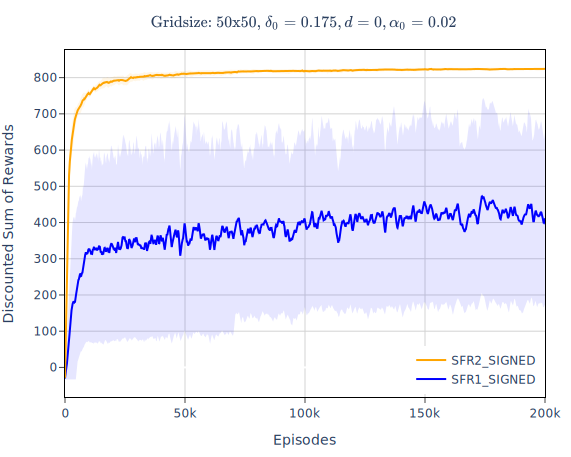

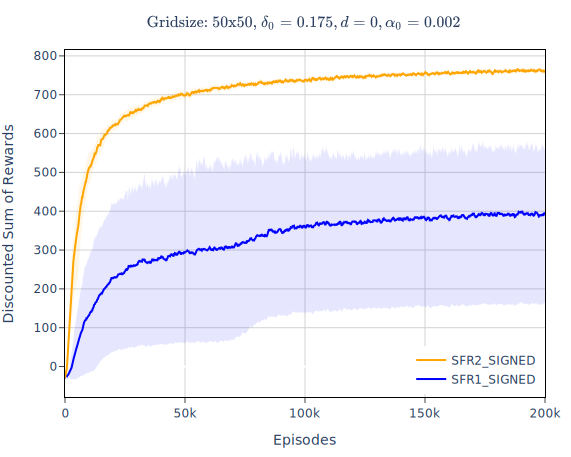

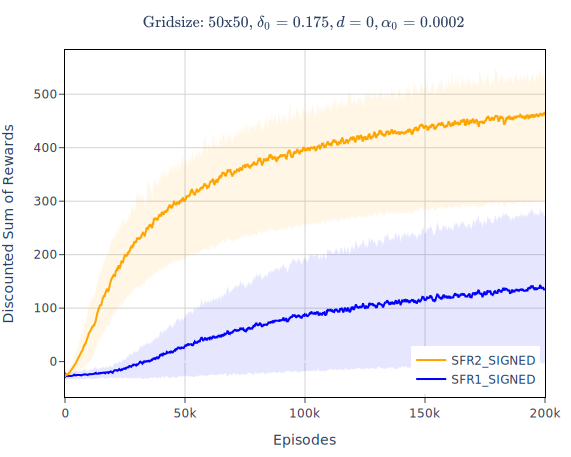

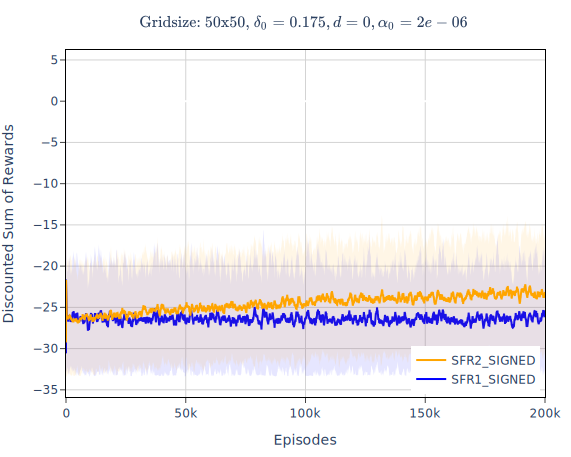

In [9]:
grid, gridsize = "large", "50x50"
suffixes = [
    "const_0.175_start_alpha=0.02",
    "const_delta=0.175_start_alpha=0.002",
    "const_0.175_start_alpha=0.0002",
    "const_0.175_start_alpha=2e-06",
]
algos = ["sf_reinforce_signed", "two_sided_sf_reinforce_signed"]
colors = ["blue", "orange"]

for suffix in suffixes:
    fig = go.Figure()
    for algo, color in zip(algos, colors):
        name = algo + "_" + suffix
        dirname = os.path.join("saves", name, grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        avg_rewards, bot, top = get_results(path, 800)
        plot_values(fig, avg_rewards, top, bot, to_paper_name(algo).upper(), color)

    title = rf"$\text{{Gridsize: {gridsize}, }} \delta_0=0.175, d=0, \alpha_0={suffix.split('=')[-1]}$"
    update_layout(fig, title)

    start_alpha = float(suffix.split("=")[-1])
    match start_alpha:
        case 2e-2:
            size = "large"
        case 2e-3:
            size = "medium_large"
        case 2e-4:
            size = "medium"
        case 2e-6:
            size = "small"
        case _:
            size = "none"
    save_name = f"plotly_images/sfr_sgn_{size}.png"
    fig.write_image(save_name, scale=2)
    fig.show(renderer="svg")

## Grad Clip by value and norm 

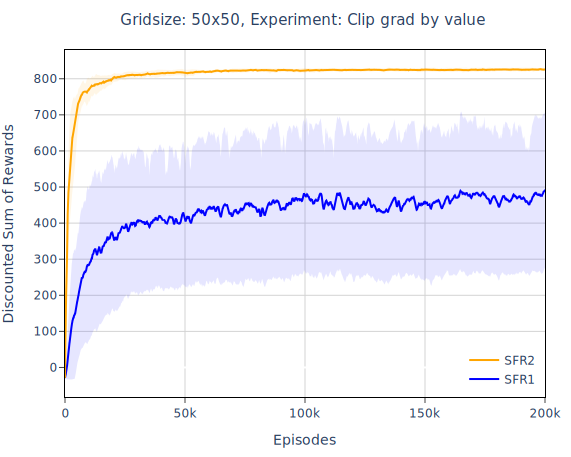

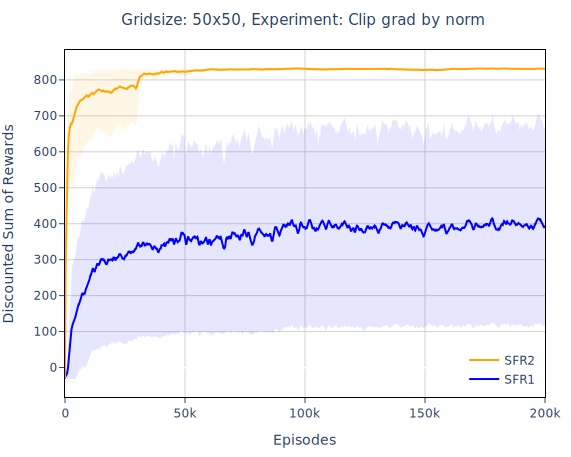

In [10]:
exps = {
    "Clip grad by value": [
        "sf_reinforce_const_delta=0.5_start_alpha=0.02_grad_bound=1.5",
        "two_sided_sf_reinforce_const_delta=0.175_start_alpha=0.02_grad_bound=1.5",
    ],
    "Clip grad by norm": [
        "sf_reinforce_const_delta=0.175_start_alpha=0.0002_grad_norm=50.0",
        "two_sided_sf_reinforce_const_delta=0.175_start_alpha=0.02_grad_norm=5.0",
    ]
}

save_names = {
    "Clip grad by value": "plotly_images/grad_clip.png",
    "Clip grad by norm": "plotly_images/grad_norm.png",
}

grid, gridsize = "large", "50x50"
algos = ["SFR1", "SFR2"]
colors = ["blue", "orange"]
for exp, names in exps.items():
    fig = go.Figure()
    for algo, name, color in zip(algos, names, colors):
        dirname = os.path.join("saves", name, grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        avg_rewards, bot, top = get_results(path, 800)
        plot_values(fig, avg_rewards, top, bot, to_paper_name(algo), color)
    title = f"Gridsize: {gridsize}, Experiment: {exp}"#fr"$\text{{Gridsize: {gridsize}, }} \delta_0={delta}, d=0, \alpha_0={start_alpha}, {max_item_name}={bound}$"

    update_layout(fig, title)
    fig.write_image(save_names[exp], scale=2)
    fig.show(renderer="svg")

In [11]:
images = set(os.listdir("images"))
plotly_images = set(os.listdir("plotly_images"))
images - plotly_images

{'const_delta.png',
 'features.png',
 'grid_small.png',
 'grid_tiny.png',
 'policy.png',
 'signed.png',
 'vanilla.png'}

In [12]:
import pandas as pd
import seaborn as sns
sns.set()

In [13]:
frames = []
for algo in ["ppo", "reinforce", "sf_reinforce", "two_sided_sf_reinforce"]:
    df = pd.read_csv(f"{algo}.txt")
    # df["perf"] = df.groupby("Seed").Reward.mean()
    df["algo"] = algo
    df = df[df.Episode % 1000 == 0]
    frames.append(df)

df = pd.concat(frames, ignore_index=True)
df.Time = df.Time.apply(lambda x: (x // 100) * 100)
df = df.groupby(["algo", "Episode"])[["Reward", "Time"]].mean().reset_index()

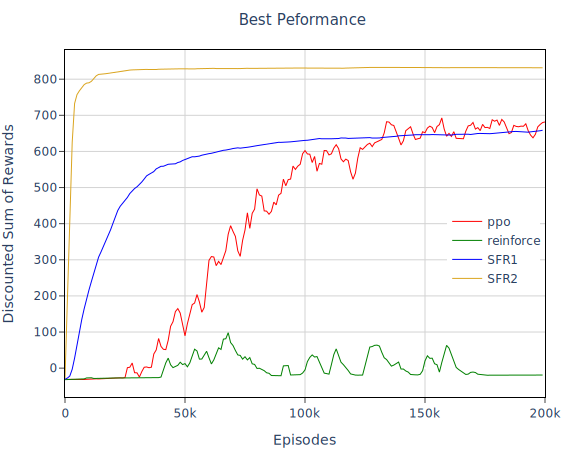

In [14]:
fig = go.Figure()
colors = ["red", "green", "blue", "goldenrod", "magenta"]
for (algo, frame), color in zip(df.groupby("algo"), colors):
    frame.Reward = frame.Reward.rolling(3, min_periods=1).mean()
    frame = frame[frame.Episode <= 2e5]
    fig.add_trace(
        go.Scatter(
            x=frame.Episode,
            y=frame.Reward,
            mode="lines",
            line=dict(width=1, color=color),
            name=to_paper_name(algo),
        )
    )
update_layout(fig, "Best Peformance")
fig.update_layout(
    legend=dict(yanchor="bottom", y=0.3, xanchor="right", x=0.99),
)
fig.write_image("plotly_images/best.png", scale=2)
fig.show(renderer="svg")

In [15]:

frames = []
for thresh in [200, 400, 600, 700, 800]:
    data = df[df.Reward > thresh].groupby("algo")[["Time", "Episode"]].min().astype(int).reset_index()
    data["thresh"] = thresh
    frames.append(data)
data = pd.concat(frames)
print(data.pivot(index="algo", columns="thresh", values="Episode").fillna(0).astype(int).to_latex(escape=True))

\begin{tabular}{lrrrrr}
\toprule
thresh & 200 & 400 & 600 & 700 & 800 \\
algo &  &  &  &  &  \\
\midrule
ppo & 51000 & 68000 & 99000 & 134000 & 0 \\
sf\_reinforce & 9000 & 19000 & 63000 & 0 & 0 \\
two\_sided\_sf\_reinforce & 1000 & 1000 & 2000 & 3000 & 11000 \\
\bottomrule
\end{tabular}



In [16]:
data.pivot(index="algo", columns="thresh", values="Time")

thresh                      200      400      600      700     800
algo                                                              
ppo                     16100.0  21600.0  32370.0  43400.0     NaN
sf_reinforce             8570.0  16970.0  48650.0      NaN     NaN
two_sided_sf_reinforce    760.0    760.0   1390.0   2010.0  6670.0

<Axes: xlabel='thresh', ylabel='Time'>

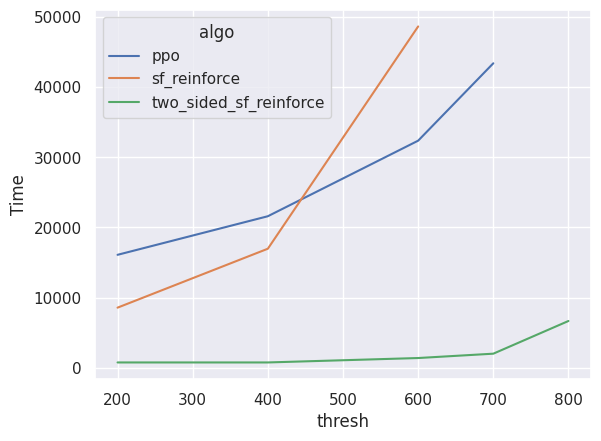

In [17]:
sns.lineplot(x="thresh", y="Time", hue="algo", data=data)